# Binary Classification Model for Customer Transaction Prediction Using Python (eXtreme Gradient Boosting Batch Testing) Take 19
### David Lowe
### April 10, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a prediction model using various machine learning algorithms and to document the end-to-end steps using a template. The Santander Bank Customer Transaction Prediction competition is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: Santander Bank's data science team wants to identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The bank is continually challenging its machine learning algorithms to make sure they can more accurately identify new ways to solve its most common challenges such as: Will a customer buy this product? Can a customer pay this loan?

For this iteration, we will examine the effectiveness of the eXtreme Gradient Boosting (XGBoost) algorithm with the synthetic over-sampling technique (SMOTE) to mitigate the effect of imbalanced data for this problem. Submissions are evaluated on the area under the ROC curve between the predicted probability and the observed target.

ANALYSIS: The performance from the training dataset achieved an average ROC-AUC score of 0.????.

CONCLUSION: After submitting the test dataset to Kaggle, the trained model processed the test dataset with a ROC-AUC score of 0.????.

Dataset Used: Santander Customer Transaction Prediction

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://www.kaggle.com/c/santander-customer-transaction-prediction/data

One potential source of performance benchmark: https://www.kaggle.com/c/santander-customer-transaction-prediction/overview

The project aims to touch on the following areas:

* Document a predictive modeling problem end-to-end.
* Explore data cleaning and transformation options
* Explore non-ensemble and ensemble algorithms for baseline model performance
* Explore algorithm tuning techniques for improving model performance

Any predictive modeling machine learning project genrally can be broken down into about six major tasks:

1. Prepare Problem
2. Summarize Data
3. Prepare Data
4. Model and Evaluate Algorithms
5. Improve Accuracy or Results
6. Finalize Model and Present Results

## Section 1 - Prepare Problem
### 1.a) Load ibraries

In [1]:
import math
import numpy as np
import pandas as pd
import os
import sys
import shutil
import urllib.request
import zipfile
import warnings
import smtplib
from datetime import datetime
from email.message import EmailMessage
from matplotlib import pyplot
from pandas import read_csv
from pandas import get_dummies
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.externals.joblib import dump
from sklearn.externals.joblib import load
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
# from imblearn.combine import SMOTEENN
# from imblearn.combine import SMOTETomek

# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.ensemble import BaggingClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from imblearn.ensemble import BalancedRandomForestClassifier
# from imblearn.ensemble import RUSBoostClassifier
# from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBClassifier

# Create one random seed number for reproducible results
seedNum = 888

### 1.b) Set up the email notification function

In [2]:
def email_notify(msg_text):
    sender = os.environ.get('MAIL_USERNAME')
    password = os.environ.get('MAIL_PASSWORD')
    receiver = os.environ.get('MAIL_RECEIVER')
    if sender==None or password==None or receiver==None :
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Python Binary Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(sender, password)
    server.send_message(msg)
    server.quit()

In [3]:
email_notify("Library and Data Loading has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [4]:
startTimeScript = datetime.now()

inputFile = 'train.csv'
x_original_df = read_csv(inputFile, sep=',', index_col=False)
print(x_original_df.head())

   ID_code  target    var_0   var_1    var_2   var_3    var_4   var_5   var_6  \
0  train_0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187   
1  train_1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208   
2  train_2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427   
3  train_3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428   
4  train_4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405   

     var_7   ...     var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266   ...      4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  16.5338   ...      7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  14.6155   ...      2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  14.9250   ...      4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  19.2514   ...     -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784

In [5]:
x_original_df.drop('ID_code',axis=1,inplace=True)
print(x_original_df.head())

   target    var_0   var_1    var_2   var_3    var_4   var_5   var_6    var_7  \
0       0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187  18.6266   
1       0  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208  16.5338   
2       0   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427  14.6155   
3       0  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428  14.9250   
4       0   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405  19.2514   

    var_8   ...     var_190  var_191  var_192  var_193  var_194  var_195  \
0 -4.9200   ...      4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  3.1468   ...      7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2 -4.9193   ...      2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3 -5.8609   ...      4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  6.2654   ...     -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5

In [6]:
y_original_df = x_original_df.iloc[:,0]
print(y_original_df.head())

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64


In [7]:
x_original_df.drop('target',axis=1,inplace=True)
print(x_original_df.head())

     var_0   var_1    var_2   var_3    var_4   var_5   var_6    var_7   var_8  \
0   8.9255 -6.7863  11.9081  5.0930  11.4607 -9.2834  5.1187  18.6266 -4.9200   
1  11.5006 -4.1473  13.8588  5.3890  12.3622  7.0433  5.6208  16.5338  3.1468   
2   8.6093 -2.7457  12.0805  7.8928  10.5825 -9.0837  6.9427  14.6155 -4.9193   
3  11.0604 -2.1518   8.9522  7.1957  12.5846 -1.8361  5.8428  14.9250 -5.8609   
4   9.8369 -1.4834  12.8746  6.6375  12.2772  2.4486  5.9405  19.2514  6.2654   

    var_9   ...     var_190  var_191  var_192  var_193  var_194  var_195  \
0  5.7470   ...      4.4354   3.9642   3.1364   1.6910  18.5227  -2.3978   
1  8.0851   ...      7.6421   7.7214   2.5837  10.9516  15.4305   2.0339   
2  5.9525   ...      2.9057   9.7905   1.6704   1.6858  21.6042   3.1417   
3  8.2450   ...      4.4666   4.7433   0.7178   1.4214  23.0347  -1.2706   
4  7.6784   ...     -1.4905   9.5214  -0.1508   9.1942  13.2876  -1.5121   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5

In [8]:
# Use 70% of the data to train the models and the remaining for testing/validation
validation_size = 0.30
x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(x_original_df, y_original_df, test_size=validation_size, random_state=seedNum)
print("x_original_df.shape: {} y_original_df.shape: {}".format(x_original_df.shape, y_original_df.shape))
print("x_train_df.shape: {} y_train_df.shape: {}".format(x_train_df.shape, y_train_df.shape))
print("x_test_df.shape: {} y_test_df.shape: {}".format(x_test_df.shape, y_test_df.shape))

x_original_df.shape: (200000, 200) y_original_df.shape: (200000,)
x_train_df.shape: (140000, 200) y_train_df.shape: (140000,)
x_test_df.shape: (60000, 200) y_test_df.shape: (60000,)


In [9]:
email_notify("Library and Data Loading completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 2 - Prepare Data

In [10]:
email_notify("Data Cleaning and Transformation has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 2.a) Data Transforms

In [11]:
# Sample code for performing SMOTE transformation on the training data (Block #1 of 2)
x_train_imbal = x_train_df.values
y_train_imbal = y_train_df.values.ravel()
print("x_train_imbal.shape: {} y_train_imbal.shape: {}".format(x_train_imbal.shape, y_train_imbal.shape))

x_train_imbal.shape: (140000, 200) y_train_imbal.shape: (140000,)


In [12]:
# Sample code for performing SMOTE transformation on the training data (Block #2 of 2)
print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
sm = SMOTE(random_state=seedNum, sampling_strategy=1.0)
x_train, y_train = sm.fit_resample(x_train_imbal, y_train_imbal)
print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

Original class distribution - 1: 14199 | 0: 125801
Resampled class distribution - 1: 125801 | 0: 125801


### 2.b) Display the Final Datasets for Model-Building

In [13]:
# We finalize the training and testing datasets for the modeling activities
x_test = x_test_df.values
y_test = y_test_df.values.ravel()
print("x_train.shape: {} y_train.shape: {}".format(x_train.shape, y_train.shape))
print("x_test.shape: {} y_test.shape: {}".format(x_test.shape, y_test.shape))

x_train.shape: (251602, 200) y_train.shape: (251602,)
x_test.shape: (60000, 200) y_test.shape: (60000,)


In [14]:
email_notify("Data Cleaning and Transformation completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Section 3 - Model Building and Tuning

In [15]:
email_notify("Model Building and Tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Set test options and evaluation metric

In [16]:
# Run algorithms using 10-fold cross validation
num_folds = 10
scoring = 'roc_auc'

In [17]:
# Set up the comparison array
models = []
results = []
names = []
metrics = []

### 3.b) Algorithm Training and Tuning

In [18]:
# Set up Algorithms Spot-Checking Array
models.append(('XGB-Trial19-1', XGBClassifier(random_state=seedNum, n_jobs=6, max_depth=20, learning_rate=0.1, n_estimators=100)))
models.append(('XGB-Trial19-2', XGBClassifier(random_state=seedNum, n_jobs=6, max_depth=20, learning_rate=0.1, n_estimators=100)))
models.append(('XGB-Trial19-3', XGBClassifier(random_state=seedNum, n_jobs=6, max_depth=20, learning_rate=0.1, n_estimators=100)))
models.append(('XGB-Trial19-4', XGBClassifier(random_state=seedNum, n_jobs=6, max_depth=20, learning_rate=0.1, n_estimators=100)))
models.append(('XGB-Trial19-5', XGBClassifier(random_state=seedNum, n_jobs=6, max_depth=20, learning_rate=0.1, n_estimators=100)))
models.append(('XGB-Trial19-6', XGBClassifier(random_state=seedNum, n_jobs=6, max_depth=20, learning_rate=0.05, n_estimators=100)))
models.append(('XGB-Trial19-7', XGBClassifier(random_state=seedNum, n_jobs=6, max_depth=20, learning_rate=0.05, n_estimators=100)))
models.append(('XGB-Trial19-8', XGBClassifier(random_state=seedNum, n_jobs=6, max_depth=20, learning_rate=0.05, n_estimators=100)))
models.append(('XGB-Trial19-9', XGBClassifier(random_state=seedNum, n_jobs=6, max_depth=20, learning_rate=0.05, n_estimators=100)))
models.append(('XGB-Trial19-10', XGBClassifier(random_state=seedNum, n_jobs=6, max_depth=20, learning_rate=0.05, n_estimators=100)))

In [19]:
# Generate model in turn
for name, model in models:
    email_notify("Algorithm "+name+" modeling and testing has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
    startTimeModule = datetime.now()
    kfold = StratifiedKFold(n_splits=num_folds, random_state=seedNum)
    cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    metrics.append(cv_results.mean())
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    print ('Model training time:',(datetime.now() - startTimeModule))
    email_notify("Algorithm "+name+" modeling completed!"+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
    testModel = model
    testModel.fit(x_train, y_train)
    predictions = testModel.predict(x_test)
    print('ROC/AUC Score: ',roc_auc_score(y_test, predictions))
    print('Accuracy Score: ',accuracy_score(y_test, predictions))
    print(classification_report(y_test, predictions)+'\n')
    email_notify("Algorithm "+name+" testing completed!"+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

XGB-Trial19-1: 0.996262 (0.008174)
Model training time: 3:35:03.767114
ROC/AUC Score:  0.5507906032703663
Accuracy Score:  0.8941333333333333
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     54101
           1       0.38      0.12      0.19      5899

   micro avg       0.89      0.89      0.89     60000
   macro avg       0.65      0.55      0.56     60000
weighted avg       0.86      0.89      0.87     60000


XGB-Trial19-2: 0.996262 (0.008174)
Model training time: 3:49:28.594059
ROC/AUC Score:  0.5507906032703663
Accuracy Score:  0.8941333333333333
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     54101
           1       0.38      0.12      0.19      5899

   micro avg       0.89      0.89      0.89     60000
   macro avg       0.65      0.55      0.56     60000
weighted avg       0.86      0.89      0.87     60000


XGB-Trial19-3: 0.996262 (0.008174)
Model training time: 3:49

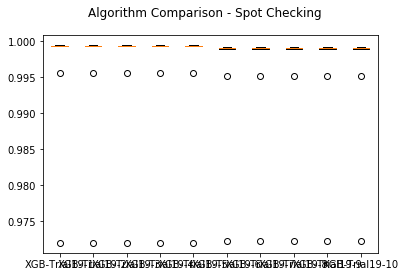

In [20]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [21]:
email_notify("Model Building and Tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [22]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 1 day, 18:10:37.642800
